Before...
=========

We developed a model for digits classification in `MLOps/data_science/working/data_science_digits_model.ipynb`.

We migrated to the cloud by adapting the notebook for **Azure Machine Learning** in `MLOps/data_science/cloud_AML_digits_model.ipynb`.

We downloaded the artifact from the Azure ML training job output and saved it in this repository under the name `model`.

In [1]:
import os

data_science_dir = os.path.join('../', "data_science")
aml_job_output = "model"

Now
===

The problem we face
-------------------

To deploy our model on a Azure ML **Real-time Endpoint**, we needed a virtual machine big enough to contain the deep neural network. Not a *very small* but a *small* VM would have been enough, such as Standard_F4s_v2 or Standard_DS2_v2.
However, we did not have enough **Endpoint quota** in our *Azure for Students* subscription for deploying the model on such a VM.

Since we cannot deploy our model on the cloud, we simulate a production environment in this notebook.

The artifact from the AzureML training job output...
----------------------------------------------------

It contains all the necessary data for reproductibility:
- environment and requirements files
- details about the ML framework (scikit-learn, tensorflow, pytorch...)
- serialized model

In [2]:
import os

def walkAmlJobOutput():
    for path, currentDirectory, files in os.walk(aml_job_output):
        for file in files:
            filepath = os.path.join(path, file)
            if os.sep+'.' not in filepath: #hide hidden files
                yield file, filepath

conda_file = None
for file, filepath in walkAmlJobOutput():
    print(filepath, end='')
    if '.yaml' in file:
        if file == "conda.yaml": conda_file = filepath
        print(" <- ENVIRONMENT FILE", end='')
    if file == "saved_model.pb":
        print(" <- SERIALIZED MODEL", end='')
    print()

model\conda.yaml <- ENVIRONMENT FILE
model\MLmodel
model\python_env.yaml <- ENVIRONMENT FILE
model\requirements.txt
model\_summary.txt
model\data\keras_module.txt
model\data\save_format.txt
model\data\model\keras_metadata.pb
model\data\model\saved_model.pb <- SERIALIZED MODEL
model\data\model\variables\variables.data-00000-of-00001
model\data\model\variables\variables.index


In [3]:
print(f"Path to Conda environment file: {conda_file}")

Path to Conda environment file: model\conda.yaml


## Install the right environment to run the model

In [4]:
with open(conda_file, 'r') as f:
    print(f.read())

channels:
- conda-forge
dependencies:
- python=3.8.15
- pip<=21.2.4
- pip:
  - mlflow
  - cffi==1.15.1
  - keras==2.6.0
  - pillow==9.4.0
  - scipy==1.7.1
  - tensorflow==2.6.0
name: mlflow-env



- Open your terminal
- Install the conda environment using `conda env create --name mlops-model-env --file <path/to/conda_file>`
- Activate it with `conda activate mlops-model-env`
- Install your favorite package for using notebooks
- Reopen this notebook

Additionally, install opencv using `conda install -c conda-forge opencv` for the deployement.

Configuration of the production simulation
------------------------------------------

In [5]:
import os, random
from PIL import Image
import numpy as np
import pandas as pd

import working.data_simulation as ds

mnist_dir = os.path.join(data_science_dir, 'input', 'test.csv')
devanagari_dir = os.path.join('foreign_data', 'DevanagariHandwrittenDigitDataset', 'Test')
japanese_dir = os.path.join('foreign_data', 'Japanese Handwritten Digits')

data_descriptions = {
    'mnist': {
        'source': pd.read_csv(mnist_dir),
        'num_samples': 100,
        'dist': lambda size: np.ones(size) / 10,
        'noise': lambda size: 0.1 * np.random.rand(size)
    },
#    'japanese': {
#        'source': ds.dataDirToDataFrame(japanese_dir),
#        'num_samples': 100,
#        'dist': lambda size: 0.5 * np.sin(
#                    np.concatenate((np.zeros(size//5),
#                                    np.linspace(0.0, np.pi, size//5),
#                                    np.zeros(size//5),
#                                    np.linspace(0.0, np.pi, size//5),
#                                    np.zeros(size//5 + size%5),
#                                   ))),
#        'noise': lambda size: 0.25 * 
#                    np.concatenate((np.zeros(size//5),
#                                    np.random.rand(size//5)*2-1,
#                                    np.zeros(size//5),
#                                    np.random.rand(size//5)*2-1,
#                                    np.zeros(size//5 + size%5),
#                                   ))
#    },
    'devanagari': {
        'source': ds.dataDirToDataFrame(devanagari_dir),
        'num_samples': 100,
        'dist': lambda size: -np.linspace(0, 1, size)**2 + 1.68 * np.linspace(0, 1, size) - 0.5,
        'noise': lambda size: 0.1 * np.linspace(0, 1, size) * np.random.rand(size)*2
    }
}

df, dfs_weights = ds.getSimulationData(data_descriptions)

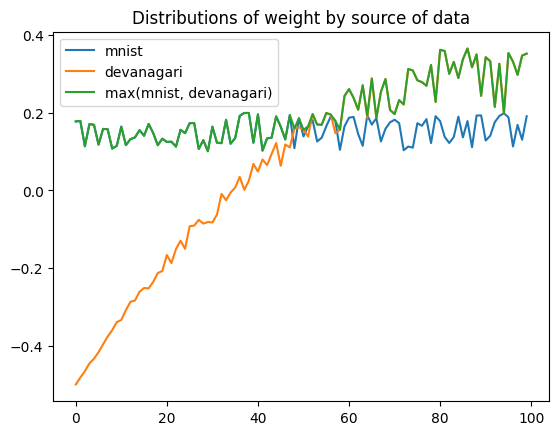

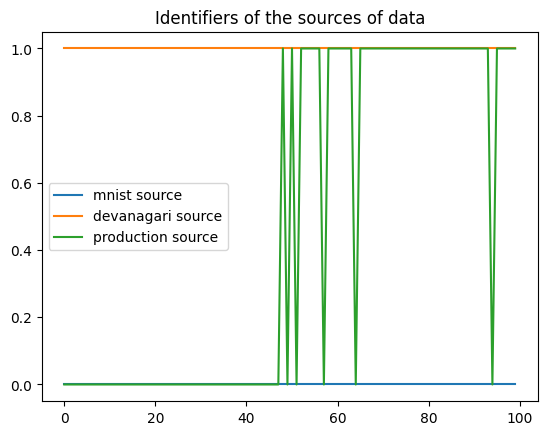

Percentage of samples from each source:
source
0    53.0
1    47.0
Name: weight, dtype: float64


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

for name, weights in zip(data_descriptions.keys(), dfs_weights):
    plt.plot(weights, label=name)
plt.plot(df.weight, label=f"max({', '.join(data_descriptions.keys())})")
plt.title('Distributions of weight by source of data')
plt.legend(); plt.show()

for source, name in enumerate(data_descriptions.keys()):
    plt.plot(np.ones(len(df)) * source, label=f"{name} source")
plt.title('Identifiers of the sources of data')
plt.plot(df.source, label= "production source")
plt.legend(); plt.show()

print('Percentage of samples from each source:')
print(df.groupby('source')['weight'].count()/len(df)*100)

In [7]:
df_prod = df.drop(['weight', 'source'], axis=1).astype(np.uint8)

## Deploy the MLFlow model in production

In [8]:
import os

prod_src_dir = "./working"
os.makedirs(prod_src_dir, exist_ok=True)

In [9]:
%%writefile {prod_src_dir}/score.py
import os, json, random, mlflow
import pandas as pd
import numpy as np
from PIL import Image
from io import StringIO
from mlflow.pyfunc.scoring_server import predictions_to_json

tick = 0

def init(model_path):
    global model
    global input_schema
    
    # Set up MLflow tracking
    random.seed()
    experiment_name = "inference"+str(random.randint(10000,100000))
    random.seed(0)
    mlflow.set_experiment(experiment_name)
    client = mlflow.MlflowClient()
    
    model = mlflow.pyfunc.load_model(model_path)
    input_schema = model.metadata.get_input_schema()
    os.environ['MLFLOW_TRACKING_FORCE_NO_GIT'] = '1'
    os.environ['GIT_PYTHON_REFRESH'] = '0'

    
    
def parse_json_input(json_data):
    json_df = pd.read_json(json.dumps(json_data['dataframe_split']), orient='split')
    data = json_df.values.astype('float32')
    data = data.reshape(1, 28, 28, 1)
    return data


def average(lst):
    return sum(lst) / len(lst)


def run(raw_data):
    global tick
    tick += 1
    
    json_data = json.loads(raw_data)
    if 'dataframe_split' not in json_data.keys():
        raise Exception("Request must contain a top level key named 'dataframe_split'")

    data = parse_json_input(json_data)
    
    # Log the data as an artifact
    with mlflow.start_run() as run:
        run_id = run.info.run_id
        Image.fromarray(data.reshape(28,28).astype(np.uint8)).save('data.png')
        mlflow.log_artifact("data.png")
    
    # Make predictions and log them
    with mlflow.start_run(run_id=run_id):
        predictions = model.predict(data)
        
        mlflow.log_metric("tick", tick)
        
        best_prediction = int(np.argmax(predictions, axis=1))
        best_proba = np.max(predictions, axis=1)
        worst_proba = np.min(predictions, axis=1)
        
        # log predicted probabilities as metrics
        for i, p in enumerate(predictions[0]):
            mlflow.log_metric(f'probability_class_{i}', p)
        mlflow.log_metric("prediction", best_prediction)
        
        # Log the predictions as an artifact
        with open("best_pred.txt", "w") as f:
            f.write(str(best_prediction))
        mlflow.log_artifact("best_pred.txt")

        # Log any anomalous predictions as a metric
        if best_proba < 0.9:
            mlflow.log_metric("anomalous_pred_proba", best_proba)
        if worst_proba > 0.01:
            mlflow.log_metric("anomalous_pred_proba", worst_proba)
        avg_preds = average(predictions[0])
        if round(avg_preds, 1) != 0.1:
            mlflow.log_metric('anomalous_avg_probas', avg_preds)
        sum_preds = sum(predictions[0])
        if round(sum_preds) != 1:
            mlflow.log_metric('anomalous_sum_probas', sum_preds)
        
    result = StringIO()
    predictions_to_json(best_prediction, result)
    return result.getvalue(), data

Overwriting ./working/score.py


In [10]:
import working.score as score

score.init(aml_job_output)
print(score.model)

2023/04/02 22:49:35 INFO mlflow.tracking.fluent: Experiment with name 'inference16421' does not exist. Creating a new experiment.
C:\Users\boiss\anaconda3\envs\mlops-model-env\lib\site-packages\keras\backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.keras
  run_id: khaki_parsnip_0nh4r3mgw2



**If you had an error (not a warning) loading the serialized model, it is probably due to Azure using another version of Python...** See `python_env.yaml`.

Try downgrading protobuf using `pip install protobuf==3.20.*` in a terminal and restarting the kernel of this notebook.

Inference in production
-----------------------

In [11]:
import os

prod_dir = "./sample_requests"
os.makedirs(prod_dir, exist_ok=True)

In [12]:
from working.dummy_server import DummyServer

server = DummyServer(df_prod, prod_dir)
server.setup()

predictions_data = []
for raw_data in server.do_GET():
    predictions_data.append(score.run(raw_data))

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [01:19<00:00,  4.58it/s]


Analysis
--------

Now, you can run `mlflow ui` in your terminal and analyse the logged metrics and artifacts!
You can also visualise the output of inference below

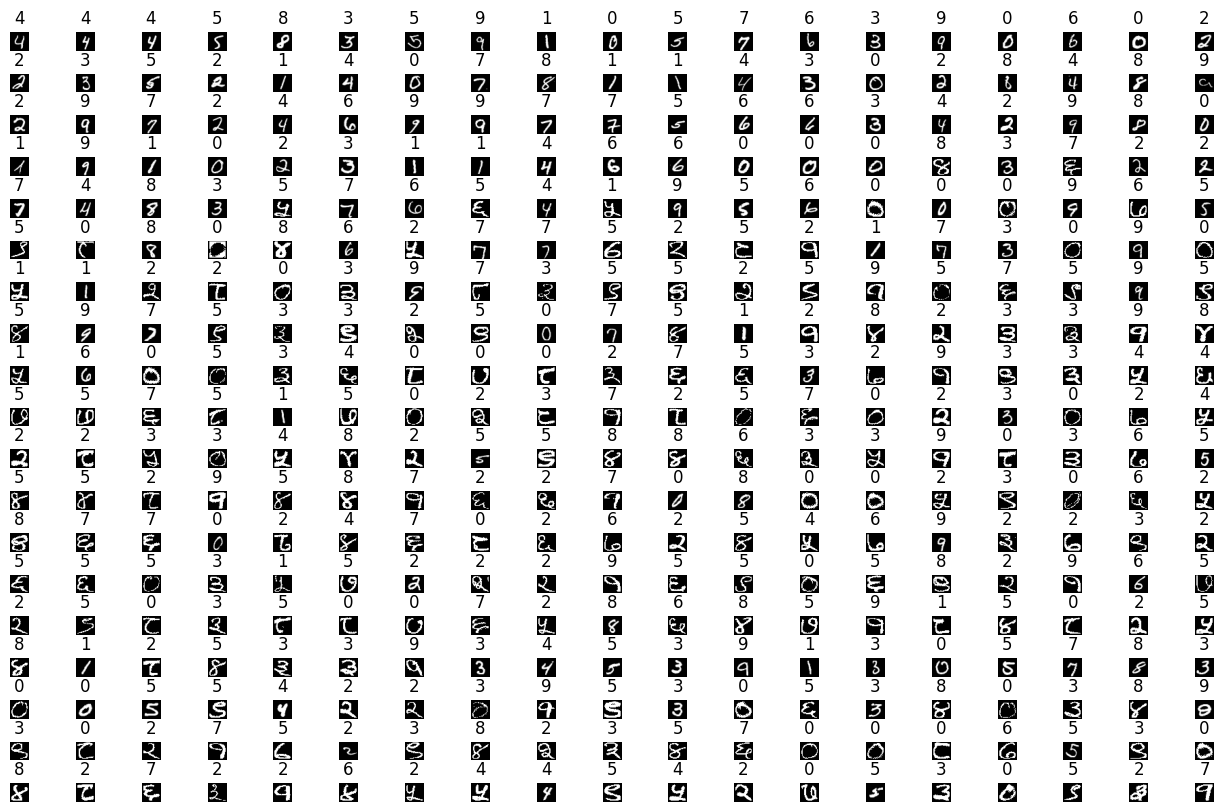

In [13]:
%matplotlib inline

from working.visualization import plot

plot(predictions_data, last=361, hspace=1.25, fig_size=(16, 10))

In [ ]:
!mlflow ui